# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [38]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [39]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [40]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.3 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=110.29323572523352, mobile=False), User(purchased=False, time_on_site=282.8663375715091, mobile=True), User(purchased=False, time_on_site=183.9557550532682, mobile=True), User(purchased=True, time_on_site=80.2039339366598, mobile=True), User(purchased=False, time_on_site=89.96574645599556, mobile=True), User(purchased=False, time_on_site=293.95698527986707, mobile=True), User(purchased=False, time_on_site=31.210251038070737, mobile=False), User(purchased=True, time_on_site=206.2588145688129, mobile=True), User(purchased=True, time_on_site=100.00803197671915, mobile=True), User(purchased=False, time_on_site=291.8395520471891, mobile=False)]


In [41]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head()

,purchased,time_on_site,mobile
0,False,110.293236,False
1,False,282.866338,True
2,False,183.955755,True
3,True,80.203934,True
4,False,89.965746,True


In [42]:
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.868,0.678667
True,0.132,0.321333


In [43]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.558319422654595,6.253372753909433,6.704894105520936,6.799818736701516,7.234137419378007,7.848544822774237,7.869878405945335,7.9437868072524225,8.730206481614768,9.511411258471139,...,577.4711816809719,578.2541764831864,582.9118603922058,584.7063739274082,585.7801056568361,588.1306911756999,593.5866414499718,593.6293381204846,595.8858683481523,599.4589267429666
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,0,0,0,0,1,1,1,1,...,1,1,1,1,1,1,1,0,1,1
True,0,0,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [44]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.964, 124.338]","(124.338, 243.119]","(243.119, 361.899]","(361.899, 480.679]","(480.679, 599.459]"
purchased,,,,,
False,239,262,142,38,45
True,124,87,48,8,7


In [45]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.964, 124.338]","(124.338, 243.119]","(243.119, 361.899]","(361.899, 480.679]","(480.679, 599.459]"
purchased,,,,,
False,0.658402,0.750716,0.747368,0.826087,0.865385
True,0.341598,0.249284,0.252632,0.173913,0.134615


In [46]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.868,0.678667
True,0.132,0.321333


In [47]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once

# Live/stretch goal - how can we do that?

user_data.corr()

,purchased,time_on_site,mobile
purchased,1.000000,-0.116024,0.183816
time_on_site,-0.116024,1.000000,-0.499421
mobile,0.183816,-0.499421,1.000000


In [48]:
a = time_bins
b = user_data['purchased']
c = user_data['mobile']
pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')

purchased              False               True           
mobile                 False     True      False     True 
time_bins                                                 
(4.964, 124.338]    0.115702  0.542700  0.027548  0.314050
(124.338, 243.119]  0.120344  0.630372  0.014327  0.234957
(243.119, 361.899]  0.263158  0.484211  0.015789  0.236842
(361.899, 480.679]  0.826087  0.000000  0.173913  0.000000
(480.679, 599.459]  0.865385  0.000000  0.134615  0.000000

In [49]:
series = pd.cut(user_data['time_on_site'], 5)
user_data['bin'] = series

for b in user_data.bin.unique():
  print(user_data[user_data.bin == b].head())

   purchased  time_on_site  mobile               bin
0      False    110.293236   False  (4.964, 124.338]
3       True     80.203934    True  (4.964, 124.338]
4      False     89.965746    True  (4.964, 124.338]
6      False     31.210251   False  (4.964, 124.338]
8       True    100.008032    True  (4.964, 124.338]
    purchased  time_on_site  mobile                 bin
1       False    282.866338    True  (243.119, 361.899]
5       False    293.956985    True  (243.119, 361.899]
9       False    291.839552   False  (243.119, 361.899]
18      False    287.539017    True  (243.119, 361.899]
24      False    327.985897   False  (243.119, 361.899]
    purchased  time_on_site  mobile                 bin
2       False    183.955755    True  (124.338, 243.119]
7        True    206.258815    True  (124.338, 243.119]
10       True    231.524893    True  (124.338, 243.119]
11      False    200.764605    True  (124.338, 243.119]
12      False    209.772810    True  (124.338, 243.119]
     purch

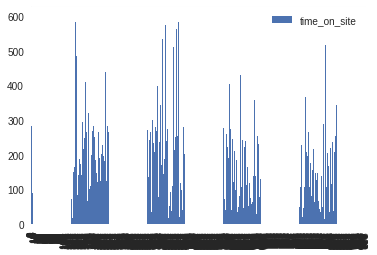

In [50]:
user_data.plot.bar();

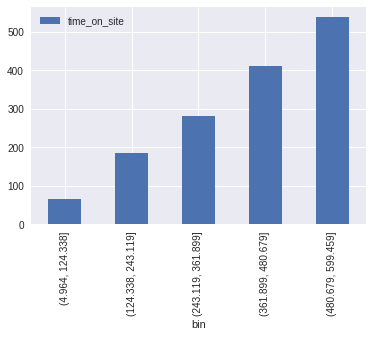

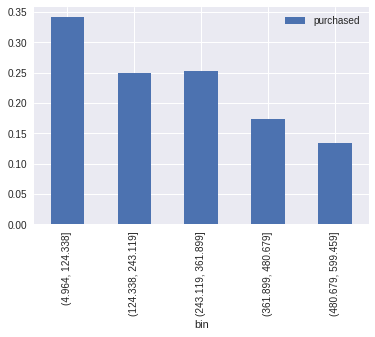

In [51]:
pd.pivot_table(user_data,values='time_on_site',index='bin').plot.bar()
pd.pivot_table(user_data,values='purchased',index='bin').plot.bar()

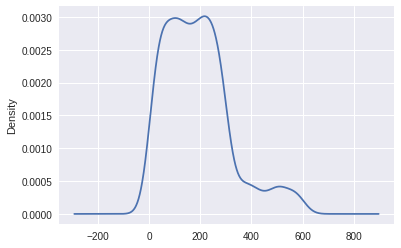

In [52]:
user_data['time_on_site'].plot.density()

In [53]:
ct = pd.crosstab(time_bins, [user_data['purchased'], user_data['mobile']],
                 normalize='columns')
ct

purchased              False               True           
mobile                 False     True      False     True 
time_on_site                                              
(4.964, 124.338]    0.193548  0.387033  0.303030  0.473029
(124.338, 243.119]  0.193548  0.432220  0.151515  0.340249
(243.119, 361.899]  0.230415  0.180747  0.090909  0.186722
(361.899, 480.679]  0.175115  0.000000  0.242424  0.000000
(480.679, 599.459]  0.207373  0.000000  0.212121  0.000000

In [0]:
#help(ct.plot)

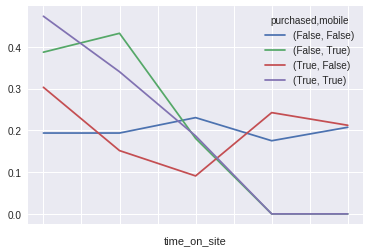

In [55]:
ct.plot() # Works but kind of weird to interpret

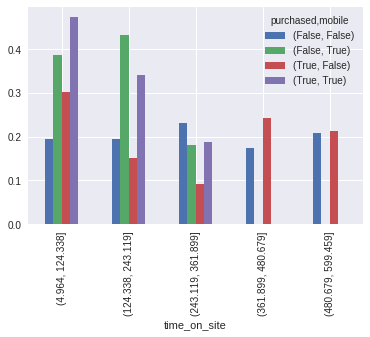

In [56]:
ct.plot(kind='bar')

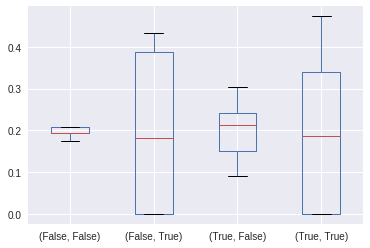

In [57]:
ct.boxplot()

In [58]:
ct2 = pd.crosstab(user_data['purchased'], [user_data['mobile'], time_bins],
                  normalize='columns')
ct2

mobile                  False                                        \
time_on_site (4.964, 124.338] (124.338, 243.119] (243.119, 361.899]   
purchased                                                             
False                0.807692           0.893617           0.943396   
True                 0.192308           0.106383           0.056604   

mobile                                                        True   \
time_on_site (361.899, 480.679] (480.679, 599.459] (4.964, 124.338]   
purchased                                                             
False                  0.826087           0.865385         0.633441   
True                   0.173913           0.134615         0.366559   

mobile                                                                 \
time_on_site (124.338, 243.119] (243.119, 361.899] (361.899, 480.679]   
purchased                                                               
False                  0.728477           0.671533                0.0   
True                   0.271523           0.328467                0.0   

mobile                           
time_on_site (480.679, 599.459]  
purchased                        
False                       0.0  
True                        0.0

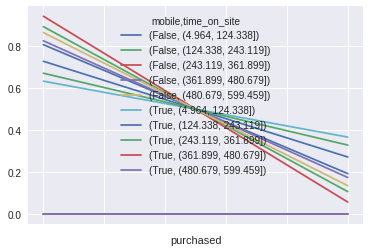

In [59]:
ct2.plot()  # Ehh too many dimensions/colors

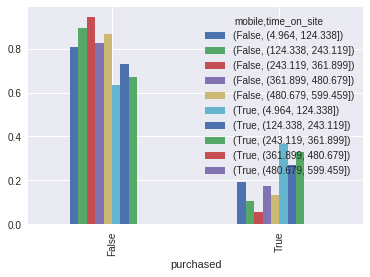

In [60]:
ct2.plot(kind='bar')

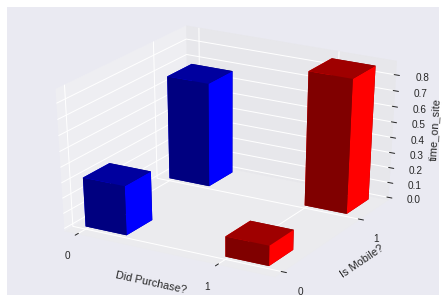

In [61]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns').values

column_names = ['True','False']
row_names = ['True','False']
fig = plt.figure()
ax = Axes3D(fig)

lx= 2 
ly= 2
xpos = np.array([1,0])
ypos = np.array([1,0])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.3 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'b'] * ly

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cs)

ax.axes.set_xticks([1,0])
ax.axes.set_yticks([1,0])
ax.set_xlabel('Did Purchase?')
ax.set_ylabel('Is Mobile?')
ax.set_zlabel('time_on_site')

plt.show()

In [62]:
user_data['purchased_num'] = user_data['purchased'] * 1
df = user_data.groupby(['mobile', 'bin'])['purchased_num'].mean()
df = df.reset_index()
df

,mobile,bin,purchased_num
0,False,"(4.964, 124.338]",0.192308
1,False,"(124.338, 243.119]",0.106383
2,False,"(243.119, 361.899]",0.056604
3,False,"(361.899, 480.679]",0.173913
4,False,"(480.679, 599.459]",0.134615
5,True,"(4.964, 124.338]",0.366559
6,True,"(124.338, 243.119]",0.271523
7,True,"(243.119, 361.899]",0.328467


In [0]:
#help(pd.cut) Try different binning. Try ensuring mobile stops at 300 


In [63]:
# groupby -- a useful utility
grouped_data = user_data['mobile'].groupby(user_data['purchased'])
help(grouped_data)

Help on SeriesGroupBy in module pandas.core.groupby object:

class SeriesGroupBy(GroupBy)
 |  Class for grouping and aggregating relational data. See aggregate,
 |  transform, and apply functions on this object.
 |  
 |  It's easiest to use obj.groupby(...) to use GroupBy, but you can also do:
 |  
 |  ::
 |  
 |      grouped = groupby(obj, ...)
 |  
 |  Parameters
 |  ----------
 |  obj : pandas object
 |  axis : int, default 0
 |  level : int, default None
 |      Level of MultiIndex
 |  groupings : list of Grouping objects
 |      Most users should ignore this
 |  exclusions : array-like, optional
 |      List of columns to exclude
 |  name : string
 |      Most users should ignore this
 |  
 |  Notes
 |  -----
 |  After grouping, see aggregate, apply, and transform functions. Here are
 |  some other brief notes about usage. When grouping by multiple groups, the
 |  result index will be a MultiIndex (hierarchical) by default.
 |  
 |  Iteration produces (key, group) tuples, i.e. chu

In [64]:
for key, group in grouped_data:
  print(key)
  print(group)

False
0      False
1       True
2       True
4       True
5       True
6      False
9      False
11      True
12      True
13      True
14      True
16      True
17      True
18      True
19      True
20     False
21      True
22      True
23     False
24     False
27      True
28     False
29      True
31      True
33     False
34      True
35      True
36      True
38      True
39     False
       ...  
959     True
960    False
961    False
963    False
964     True
965    False
966     True
967    False
968     True
970    False
971     True
972    False
974     True
976     True
977     True
978     True
980    False
982     True
983     True
984     True
985    False
986     True
988     True
989    False
991     True
992     True
993    False
997     True
998    False
999    False
Name: mobile, Length: 726, dtype: bool
True
3       True
7       True
8       True
10      True
15     False
25      True
26     False
30      True
32      True
37      True
41      True
48      True
5

In [67]:
# From Chris Luedtke
user_data['purchased_num'] = user_data['purchased'] * 1
df = user_data.groupby(['mobile', 'bin'])['purchased_num'].mean()
df = df.reset_index()
df

,mobile,bin,purchased_num
0,False,"(4.964, 124.338]",0.192308
1,False,"(124.338, 243.119]",0.106383
2,False,"(243.119, 361.899]",0.056604
3,False,"(361.899, 480.679]",0.173913
4,False,"(480.679, 599.459]",0.134615
5,True,"(4.964, 124.338]",0.366559
6,True,"(124.338, 243.119]",0.271523
7,True,"(243.119, 361.899]",0.328467


## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [69]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

df = pd.read_csv('https://raw.githubusercontent.com/LambdaSchool/DS-Sprint-01-Dealing-With-Data/master/module4-databackedassertions/persons.csv')
df.head()

,Unnamed: 0,age,weight,exercise_time
0,0,44,118,192
1,1,41,161,35
2,2,46,128,220
3,3,39,216,57
4,4,28,116,182


In [70]:
df.describe()

,Unnamed: 0,age,weight,exercise_time
count,1200.000000,1200.000000,1200.000000,1200.000000
mean,599.500000,48.396667,153.540833,134.910833
std,346.554469,18.166802,35.132182,85.548895
min,0.000000,18.000000,100.000000,0.000000
25%,299.750000,33.000000,125.000000,65.000000
50%,599.500000,48.000000,149.000000,122.000000
75%,899.250000,64.000000,180.250000,206.000000
max,1199.000000,80.000000,246.000000,300.000000


In [155]:
df.corr()

,Unnamed: 0,age,weight,exercise_time
Unnamed: 0,1.000000,-0.000418,-0.060297,-0.020138
age,-0.000418,1.000000,0.144168,-0.273818
weight,-0.060297,0.144168,1.000000,-0.478021
exercise_time,-0.020138,-0.273818,-0.478021,1.000000


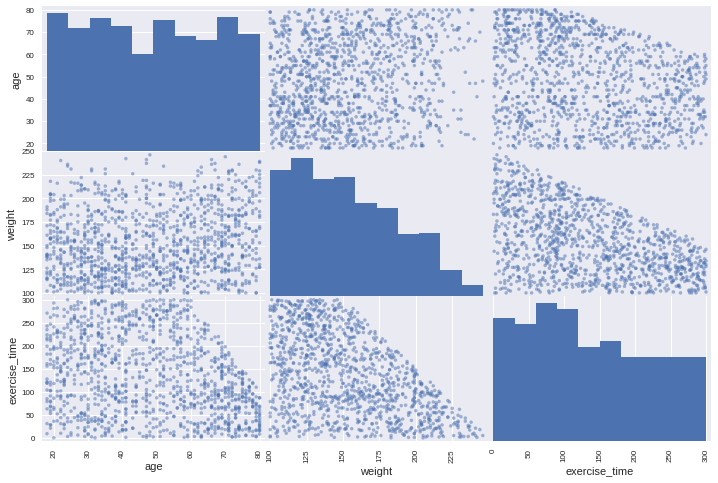

In [71]:
from pandas.plotting import scatter_matrix

attributes = ['age','weight','exercise_time']

scatter_matrix(df[attributes], figsize=(12,8))
plt.show()

In [105]:
import plotly.plotly as py
py.sign_in('tesseract314', 'Jc3LvvZzqiVNef3dsp2O')
import plotly.graph_objs as go

import numpy as np

trace1 = go.Scatter3d(
    x=df['age'],
    y=df['weight'],
    z=df['exercise_time'],
    mode='markers',
    marker=dict(
        size=8,
        line=dict(
            color='rgba(217, 217, 217, 0.14)',
            width=0.5
        ),
        opacity=0.8
    )
)

data = [trace1]
layout = go.Layout(margin=dict(l=0, r=0, b=0, t=0))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter', sharing='public')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~tesseract314/0 or inside your plot.ly account where it is named 'simple-3d-scatter'


In [0]:
#dir(py.plot)
#go.Scatter3d
#help(py.plotly)

In [146]:
age_bins = pd.cut(df['age'], 4)
weight_bins = pd.cut(df['weight'], 4)
ct3 = pd.crosstab(age_bins, weight_bins, normalize='index')
ct3

weight,"(99.854, 136.5]","(136.5, 173.0]","(173.0, 209.5]","(209.5, 246.0]"
age,,,,
"(17.938, 33.5]",0.389408,0.383178,0.161994,0.065421
"(33.5, 49.0]",0.442623,0.304918,0.196721,0.055738
"(49.0, 64.5]",0.391304,0.307971,0.228261,0.072464
"(64.5, 80.0]",0.288591,0.322148,0.261745,0.127517


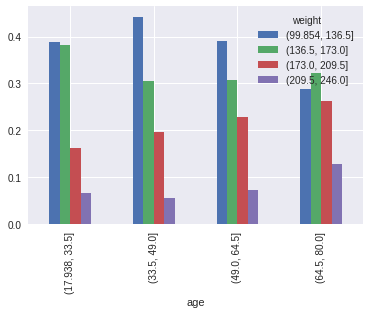

In [147]:
#help(pd.cut)
ct3.plot(kind='bar')

In [152]:
exercise_bins = pd.cut(df['exercise_time'], 4)
ct4 = pd.crosstab(age_bins, exercise_bins, normalize='index')
ct4

exercise_time,"(-0.3, 75.0]","(75.0, 150.0]","(150.0, 225.0]","(225.0, 300.0]"
age,,,,
"(17.938, 33.5]",0.242991,0.227414,0.277259,0.252336
"(33.5, 49.0]",0.229508,0.252459,0.232787,0.285246
"(49.0, 64.5]",0.250000,0.264493,0.231884,0.253623
"(64.5, 80.0]",0.463087,0.406040,0.124161,0.006711


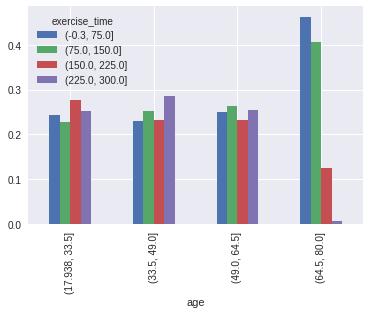

In [153]:
ct4.plot(kind='bar')

In [158]:
ct5 = pd.crosstab(weight_bins, exercise_bins, normalize='index')
ct5

exercise_time,"(-0.3, 75.0]","(75.0, 150.0]","(150.0, 225.0]","(225.0, 300.0]"
weight,,,,
"(99.854, 136.5]",0.180617,0.220264,0.264317,0.334802
"(136.5, 173.0]",0.224181,0.292191,0.261965,0.221662
"(173.0, 209.5]",0.422925,0.430830,0.146245,0.000000
"(209.5, 246.0]",0.802083,0.197917,0.000000,0.000000


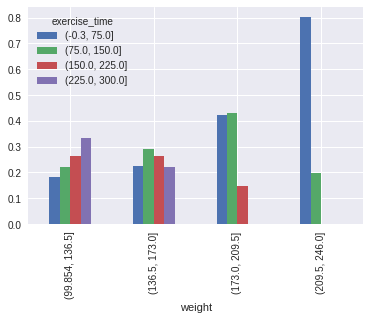

In [161]:
ct5.plot(kind='bar')

In [163]:
ct6 = pd.crosstab(exercise_bins, [age_bins, weight_bins])
ct6

age             (17.938, 33.5]                                               \
weight         (99.854, 136.5] (136.5, 173.0] (173.0, 209.5] (209.5, 246.0]   
exercise_time                                                                 
(-0.3, 75.0]                18             18             24             18   
(75.0, 150.0]               22             29             19              3   
(150.0, 225.0]              35             45              9              0   
(225.0, 300.0]              50             31              0              0   

age               (33.5, 49.0]                                               \
weight         (99.854, 136.5] (136.5, 173.0] (173.0, 209.5] (209.5, 246.0]   
exercise_time                                                                 
(-0.3, 75.0]                12             21             22             15   
(75.0, 150.0]               28             19             28              2   
(150.0, 225.0]              37             24             10              0   
(225.0, 300.0]              58             29              0              0   

age               (49.0, 64.5]                                               \
weight         (99.854, 136.5] (136.5, 173.0] (173.0, 209.5] (209.5, 246.0]   
exercise_time                                                                 
(-0.3, 75.0]                16             17             23             13   
(75.0, 150.0]               18             21             27              7   
(150.0, 225.0]              32             19             13              0   
(225.0, 300.0]              42             28              0              0   

age               (64.5, 80.0]                                               
weight         (99.854, 136.5] (136.5, 173.0] (173.0, 209.5] (209.5, 246.0]  
exercise_time                                                                
(-0.3, 75.0]                36             33             38             31  
(75.0, 150.0]               32             47             35              7  
(150.0, 225.0]              16             16              5              0  
(225.0, 300.0]               2              0              0              0

In [174]:
series = pd.cut(df['exercise_time'], 4)
df['bin'] = series

for b in df.bin.unique():
  df[df.bin == b].head()

#user_data['purchased_num'] = user_data['purchased'] * 1
#df = user_data.groupby(['mobile', 'bin'])['purchased_num'].mean()
#df = df.reset_index()
df.head()

,Unnamed: 0,age,weight,exercise_time,bin
0,0,44,118,192,"(150.0, 225.0]"
1,1,41,161,35,"(-0.3, 75.0]"
2,2,46,128,220,"(150.0, 225.0]"
3,3,39,216,57,"(-0.3, 75.0]"
4,4,28,116,182,"(150.0, 225.0]"


In [180]:
a_w_corr = df.groupby('bin')[['age', 'weight']].corr()

#help(df.groupby)
a_w_corr

age    weight
bin                                      
(-0.3, 75.0]   age     1.000000 -0.010650
               weight -0.010650  1.000000
(75.0, 150.0]  age     1.000000  0.054188
               weight  0.054188  1.000000
(150.0, 225.0] age     1.000000  0.003139
               weight  0.003139  1.000000
(225.0, 300.0] age     1.000000  0.056640
               weight  0.056640  1.000000

In [187]:
bins_corr = [{'exercise_bin': '(-0.3, 75.0]', 'age_weight_corr': -0.010650},
            {'exercise_bin': '(75.0, 150.0]',  'age_weight_corr': 0.054188},
            {'exercise_bin': '(150.0, 225.0]',  'age_weight_corr': 0.003139},
            {'exercise_bin': '(225.0, 300.0]',  'age_weight_corr': 0.056640}]
df_corr = pd.DataFrame(data=bins_corr)
df_corr.head()

,age_weight_corr,exercise_bin
0,-0.010650,"(-0.3, 75.0]"
1,0.054188,"(75.0, 150.0]"
2,0.003139,"(150.0, 225.0]"
3,0.056640,"(225.0, 300.0]"


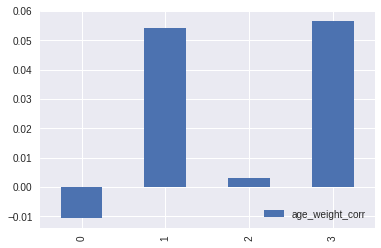

In [189]:
df_corr.plot(kind='bar');

### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?

**In actuality all three variables included in the dataset (age, weight and time) are continuous variables, which are represented in python as floats.  However, in this dataset, they are represented as integers (i.e. with no decimals).**

2.  What are the relationships between the variables?

**There are many relationships between the variables. Age and weight are positively correlated. Age and exercise time are negatively correlated. And weight and exercise time are negatively correlated.**

3.  Which relationships are "real", and which spurious?

**Age and weight do seem to affect excercise time. The older and heavier you are, the less likely you may be to do long exercises. Age and weight's effect on exercise time was more pronounced at the high end of both variables. However, age also seems to affect weight. The older you are, the heavier you get. Of course, there are exceptions to this. The correlation between age and weight was positive but not very big. Both age and weight must be considered to properly estimate exercise time. Looking at just age alone (or weight alone) compared to exercise time, may lead to spurious results.**


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)